# <font color=red>HW01-q4 Vision Course, Homography Computation</font>
This is the notebook for **q4.py** that is the implementation of **Homography Computation**. <br>
The code is written by **Asal Mehradfar** with student number **96105434**.

## <font color=orange>Description</font>
My approach is explained below:

*    I use *SIFT_create()* in open-cv for all the steps, so upgrading open-cv is needed in *Google Colab*. <br><br>
*   At the first step I exactly did the same things as the previous question upto the *findHomography* part. So I got the good matches from the function sift that I have written myself. Pay attention that I did not plot the results for each step in this section. The other important point is that I preferred not to sort the match points the same as **q3**. <br><br>
*   In the second step I wrote a function to make a matrix containing all the source and destination points, z is considered 1 here, so I have three coordinates. I implemented this part with lists at first and for testing my homography in other steps I used a for loop. But I figured that using lists and multiplying one by one takes a lot of time. <br><br>
*   Now its time to use the matrixes generated. I wrote a while loop in this part that will finish when the number of iterations reaches a special level. The level is the same as the one in **q3**. In each loop, first we pick 4 **random samples** of the source and destination points and generate a homography matrix. Then we compute the error vector and use a special threshold for it to decide if a special point is inlier or outlier. At last we compute the number of inliers and compare it with the last accepted homography. If the inliers are fewer we will go to the next loop, else we will upgrade the homography matrix and status.<br><br>
*   For generating each homography matrix by 4 points, I used the exact form of the slides for generating A. Then I used the python **SVD** to generate V and the h vector at the end. I reshaped the h vector to a 3*3 matrix and then it was needed to change the rows 1 and 2 of it. Now our homography matrix is prepared.<br><br>
*   For computing the error, I used the usual 2nd norm, that means I substracted the expected result from the current result and then computed the sqrt of the sum of the powers of two. I also checked my result with norm 1, but this result was better.<br><br>
*   The most important point about this question is that we use random samples in each loop, so results may be a bit different for each time we run the code. but we can make the results in each run more similar by adding the number of iterations.<br><br>
*   we have offset here, the same as **q3**. The offset is a bit different here.<br>
$$offset =\begin{bmatrix} 1 & 0 & X \\ 0 & 1 & Y \\ 0 & 0 & 1 \end{bmatrix} = \begin{bmatrix} 1 & 0 & 2900 \\ 0 & 1 & 1100 \\ 0 & 0 & 1 \end{bmatrix}$$
*   $$H =\begin{bmatrix} 0.00033 & 0.00004 & 0.79597 \\ -0.00003 & 0.00066 & 0.60534 \\ 0 & 0 & 0.00129 \end{bmatrix}$$
$$offset \times H^{-1} =\begin{bmatrix} 3055 & -305 & 504453 \\ 126 & 1484 & 78134 \\ 0 & 0 & 809 \end{bmatrix}$$
<br>The zeros above are not exactly zero. They are around zero. <br><br>
*   Pay attention that the result of the implemented algorithm and the sift RANSAC are almost the same. Also about **H** matrix and the final homography, if we scale the H of this part to numbers around H of q3 that means we normalize H in a way that the number in the 3rd row and 3rd column change to 1, we will see that the matrixes will be almost the same. it means that scaling is the only different.



### <font color=yellow>Upgrading Open-CV in Google Colab</font>

In [1]:
!pip3 install --upgrade opencv-python

     |████████████████████████████████| 49.9 MB 16 kB/s 
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


### <font color=yellow>Imports</font>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

### <font color=yellow>Parameters</font>

*   MAX_ITERATIONS = 10000
*   INLIER_THRESHOLD = 3

In [3]:
R = 0.7 # ratio for knn match
MAX_ITERATIONS = 10000
INLIER_THRESHOLD = 3  # this parameter is chosen to be 3, the same as the default value of sift RANSAC
X_OFFSET = 2900
Y_OFFSET = 1100
X_SIZE = 10000
Y_SIZE = 3500

### <font color=yellow>Functions</font>

In [4]:
def plot_img(img, path= None):
    """
    Plot a colorful image and save it if needed
    
    Inputs:
    --> img: the desired image
    --> path: the default value is None, if it is given the image will be saved in the path
    Outputs:
    ==> Nothing, the image will be plotted
    """
    fig = plt.figure(figsize=(16, 8))
    plt.imshow(img)
    plt.axis('off')
    if path != None:
        fig.savefig(path, bbox_inches='tight')
    plt.show()

def get_img(path):
    """
    Read the image file from the path and change it from BGR to RGB
    pay attention that in open-cv colorful images are BGR **NOT** RGB
    
    Inputs:
    --> path: path for the image
    Outputs:
    ==> img: the RGB image
    """
    img = cv2.imread(path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    return img

def sift(img1, img2, R, flag=False):
    """
    Finding match points between two images by RANSAC Algorithm

    Inputs:
    --> img1: the first desired image
    --> img2: the second desired image
    --> R: the accepted ratio for distance between matches
    -->
    Outputs:
    ==> kp1: key points of the first image
    ==> kp2: key points of the second image
    ==> good_matches: good matches of two images
    """

    sift_cr = cv2.SIFT_create()

    # find all key points
    kp1, des1 = sift_cr.detectAndCompute(img1, None)
    kp2, des2 = sift_cr.detectAndCompute(img2, None)

    # find all matches
    bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=False)
    matches = bf.knnMatch(des1, des2, k=2)

    # find good matches
    good_matches = []
    for m, n in matches:
        if m.distance < R * n.distance:
            if flag:
                good_matches.append([m])
            else:
                good_matches.append(m)

    return kp1, kp2, good_matches

def get_h(src_pts, des_pts):
    """
    Finding the homography matrix between 4 points
    
    Inputs:
    --> src_pts: a 4*1*2 array of 4 source points 
    --> des_pts: a 4*1*2 array of 4 destination points 
    Outputs:
    ==> h: the homography matrix between 4 points
    """
    n = len(src_pts)
    A = np.zeros((2 * n, 9))
    i = 0

    for s, d in zip(src_pts, des_pts):
        [x, y] = s[0]
        [xp, yp] = d[0]
        A[2 * i, :] = [-x, -y, -1, 0, 0, 0, x*yp, y*yp, yp]
        A[2 * i + 1, :] = [0, 0, 0, -x, -y, -1, x*xp, y*xp, xp]
        i += 1
    
    _, _, Vt = np.linalg.svd(A)

    h = Vt[-1, :].reshape(3, 3)
    h[[0, 1]] = h[[1, 0]]
    return h

def get_pts_mat(kp1, kp2, matches):
    """
    Making two matrixes of source and destination points 
    with regard to the third axis, z
    
    Inputs:
    --> kp1: key points of the first image
    --> kp2: key points of the second image
    --> matches: good matches of two images
    Outputs:
    ==> src_mat: the matrix of source points with z axis defined as 1
    ==> des_mat: the matrix of destination points with z axis defined as 1
    """
    src_mat = np.zeros((3, len(matches))) 
    des_mat = np.zeros((3, len(matches)))
    i = 0

    for m in matches:
        src_mat[:, i] = [kp1[m.queryIdx].pt[0], kp1[m.queryIdx].pt[1], 1]
        des_mat[:, i] = [kp2[m.trainIdx].pt[0], kp2[m.trainIdx].pt[1], 1]
        i += 1

    return src_mat, des_mat

def get_error(src_mat, des_mat, h):
    """
    Making a vector of errors generated by homography matrix h
    
    Inputs:
    --> src_mat: the matrix of source points with z axis defined as 1
    --> des_mat: the matrix of destination points with z axis defined as 1
    --> h: the homography matrix
    Outputs:
    ==> err: the vector of errors, for each set of source and destination points we have an special error 
    """
    expected_des_mat = np.dot(h, src_mat)
    expected_des_mat = expected_des_mat / expected_des_mat[2, :]
    err = np.sqrt(np.sum((des_mat - expected_des_mat) ** 2, 0))
    return err

def find_homography(kp1, kp2, matches):
    """
    Making the final homography matrix and also the status of each matched key point
    
    Inputs:
    --> kp1: key points of the first image
    --> kp2: key points of the second image
    --> matches: good matches of two images
    Outputs:
    ==> H: the best homography matrix
    ==> status: the status matrix for matches, 1 means the match is inlier and 0 zero means the match is outlier
    """

    src_mat, des_mat = get_pts_mat(kp1, kp2, matches)
    n = len(matches)
    iter = 0
    final_match = 0

    while iter < MAX_ITERATIONS:
        random_idxs = np.random.choice(n, size=4, replace=False)
        src_pts = np.float32([src_mat[:2, i] for i in random_idxs]).reshape(-1, 1, 2)
        des_pts = np.float32([des_mat[:2, i] for i in random_idxs]).reshape(-1, 1, 2)

        h = get_h(src_pts, des_pts)
        err = get_error(src_mat, des_mat, h)

        stat = [1 if err[i] < INLIER_THRESHOLD else 0 for i in range(len(matches))]
        num_of_match = np.sum(stat)
        # print(num_of_match)

        if num_of_match > final_match:
            final_match = num_of_match
            status = stat
            H = h
            
        iter += 1
    
    return H, status

def plot_inliers(H, status, kp1, kp2, matches, img1, img2):
    """
    plotting the inliers, THIS FUNCTION WAS NOT WANTED IN THE SHEET!
    
    Inputs:
    --> H: the best homography matrix
    --> status: the status matrix for matches, 1 means the match is inlier and 0 zero means the match is outlier
    --> kp1: key points of the first image
    --> kp2: key points of the second image
    --> matches: good matches of two images
    --> img1: the first desired image
    --> img2: the second desired image
    Outputs:
    ==> Nothing, just plotting the inliers
    """
    inlier = []
    for i in range(len(matches)):
        if status[i] == 1:
            inlier.append(matches[i])
    # print(len(inlier))
    inlier_lines = cv2.drawMatches(img1, kp1, img2, kp2, inlier, None, flags = 2, singlePointColor = (255, 0, 0), matchColor= (255, 0, 0))  
    plot_img(inlier_lines)

def perspective(img, H):
    """
    computing the homography of the image with matrix H

    Inputs:
    --> img: the desired image
    --> H: the homography matrix
    Outputs:
    ==> img_homography: the output image
    """
    x_min, y_min, x_max, y_max = corners_homography(img, H)
    [x_offset, y_offset] = [-x_min, -y_min]
    [x_size, y_size] = [x_max - x_min, y_max - y_min]
    offset = np.array([[1, 0, x_offset], [0, 1, y_offset], [0, 0, 1]])
    img_homography = cv2.warpPerspective(img, np.dot(offset, H), (x_size, y_size))
    return img_homography


def corners_homography(img, H):
    """
    computing the min and max of the corners of an image
    after applying the homography matrix without offset
    we use these points to find offset and size of the homography

    Inputs:
    --> img: the desired image
    --> H: the homography matrix
    Outputs:
    ==> x_min: minimum x after homography
    ==> y_min: minimum y after homography
    ==> x_max: maximum x after homography
    ==> y_max: maximum y after homography
    """
    height, width, _ = img.shape
    corners = [np.array([[0, 0, 1]]).transpose(),
               np.array([[width - 1, 0, 1]]).transpose(),
               np.array([[0, height - 1, 1]]).transpose(),
               np.array([[width - 1, height - 1, 1]]).transpose()]
    [x_min, y_min, x_max, y_max] = [-1 for _ in range(4)]
    for c in corners:
        m = np.matmul(H, c)
        if x_min == -1:
            [x_min, y_min, x_max, y_max] = [int(m[0] / m[2]),
                                            int(m[1] / m[2]),
                                            int(m[0] / m[2]),
                                            int(m[1] / m[2])]
        else:
            [x_min, y_min, x_max, y_max] = [min(x_min, int(m[0] / m[2])),
                                            min(y_min, int(m[1] / m[2])),
                                            max(x_max, int(m[0] / m[2])),
                                            max(y_max, int(m[1] / m[2]))]
    return x_min, y_min, x_max, y_max

### <font color=yellow>Main Part, Test on im03.jpg and im04.jpg</font>

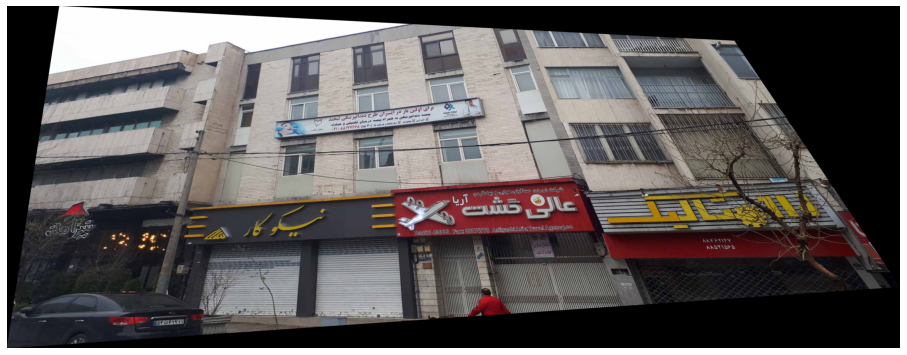

In [5]:
img1 = get_img('im03.jpg')
img2 = get_img('im04.jpg')
kp1, kp2, matches = sift(img1, img2, R)
H, status = find_homography(kp1, kp2, matches)
# plot_inliers(H, status, kp1, kp2, matches, img1, img2)
img_homography = perspective(img2, np.linalg.inv(H))
plot_img(img_homography, 'res20.jpg')